In [26]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [28]:
######Importation des données##########

X=pd.read_csv("stats_fight_mma_soustraction.csv",
                   sep='\t',index_col=0,header=None,usecols=[0,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
                                                            20,21,22,23,24,25,26,27,28,29],engine='python')


y = pd.read_csv("stats_fight_mma_soustraction.csv", sep='\t',header=None,engine='python',index_col=0, usecols=[0,30]).values.ravel()

columns=["POIDS A","TAILLE A","ANNEE A","EXPERIENCE A","VICTOIRE A","DEFAITE A","KO A",
           "SOUMISSION A","STREAK A","POIDS B","TAILLE B","ANNEE B","EXPERIENCE B","VICTOIRE B","DEFAITE B","KO B",
           "SOUMISSION B","STREAK B","DIFF POIDS","DIFF TAILLE","DIFF AGE","DIFF VICTOIRE","DIFF DEFAITE",
           "DIFF KO","DIFF SOUMISSION","DIFF STREAK"]
#transformation en matrice Numpy
X = X.values

X, X_test, y, y_test = train_test_split(X, y, test_size=0.33)

In [29]:
#Utilisaton de la librairie XGBOOST et de son classifieur
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)

XGBClassifier(base_score=0.005, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

[ 0  1  3  4  5  8  9 10 12 13 14 17 18 19 20 21 22 23 24 25]


(20,)

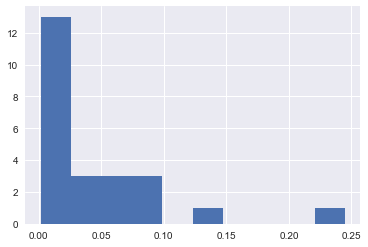

In [30]:
# Selection des bons features
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_>0.005)[0]
print(important_indices)
important_indices.shape

In [31]:
elements_retenu=[]
for i in important_indices:
    elements_retenu.append(columns[i])
elements_retenu

['POIDS A',
 'TAILLE A',
 'EXPERIENCE A',
 'VICTOIRE A',
 'DEFAITE A',
 'STREAK A',
 'POIDS B',
 'TAILLE B',
 'EXPERIENCE B',
 'VICTOIRE B',
 'DEFAITE B',
 'STREAK B',
 'DIFF POIDS',
 'DIFF TAILLE',
 'DIFF AGE',
 'DIFF VICTOIRE',
 'DIFF DEFAITE',
 'DIFF KO',
 'DIFF SOUMISSION',
 'DIFF STREAK']

In [32]:
#Cross validation 
#en conservant 3 sous echantillons avec des fréquences de classes homogènes dans chacun des sous ensembles
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
preds = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    preds[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:,1]
    print("fold {}, ROC AUC: {:.5f}".format(i, roc_auc_score(y[test], preds[test])))
print(roc_auc_score(y, preds))

fold 0, ROC AUC: 0.58942
fold 1, ROC AUC: 0.62732
fold 2, ROC AUC: 0.59445
0.602137771953


0.174439563137


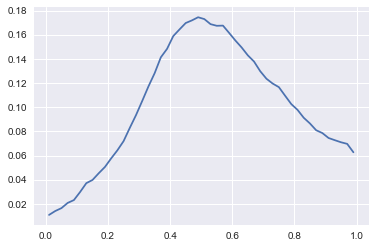

In [33]:
# on récupéere le meilleur seuil pour avoir le meilleur prédicteur selon le critère du coefficient de Mattews
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [34]:
# generate predictions at the chosen threshold
preds = (clf.predict_proba(X_test)[:,1] > best_threshold).astype(np.int8)

In [35]:
# Comparaison des predictions avec les vraies valeurs
print("ROC AUC: {:.5f}".format(roc_auc_score(y_test, preds)))

ROC AUC: 0.57354
